<a href="https://colab.research.google.com/github/mathewsjob/Master-Thesis/blob/main/Final_thesis_1/11/22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary packages**

In [1]:
import os, shutil
from google.colab import drive

In [2]:
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3

**Mounting Drive**

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size = 32
img_height = 244
img_width = 244

**Setting Path**

In [6]:
base_dir = '/content/drive/My Drive/training_set'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
data_dir = train_dir

In [7]:
os.listdir(train_dir)

['ulcerative-colitis',
 'polyps',
 'normal-z-line',
 'normal-pylorus',
 'normal-cecum',
 'esophagitis',
 'dyed-resection-margins',
 'dyed-lifted-polyps']

**Get Categories(Class) of Dataset**

In [8]:
def get_dataCategories(directory):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(directory, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])



directory = train_dir
categories, nbr_files = get_dataCategories(directory)

# Create DataFrame
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,categories,number of files
0,dyed-lifted-polyps,2000
1,dyed-resection-margins,2000
2,esophagitis,2000
3,normal-cecum,2000
4,normal-pylorus,2000
5,normal-z-line,2000
6,polyps,2000
7,ulcerative-colitis,2000


**Loading training dataset**

It’s good practice to use a validation split when developing your model. We will use 80% of the images for training and 20% for validation.

Validation_split float between 0 and 1. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. Shuffle the training data before each epoch.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.
Using 12800 files for training.


**Loading validation dataset**

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.
Using 3200 files for validation.


In [11]:
train_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.


# Augmentation and Normalization

In [12]:
def norm_data (ds):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))
  
  return norm_ds


In [13]:
def augument_data (ds, crop_size):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = norm_ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds


In [14]:
def augument_data1 (ds, crop_size):

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds



In [15]:
train_ds_aug = augument_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)

In [16]:
val_ds_aug = augument_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)

In [17]:
train_all_aug = augument_data1 (train_all, img_height-20)
train_all_norm = norm_data (train_all_aug)

In [18]:
# performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
train_all_norm = train_all_norm.cache().prefetch(buffer_size=AUTOTUNE)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
train_all_aug = train_all_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
class_names = train_ds.class_names
print(class_names)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


**Examples of original images:**

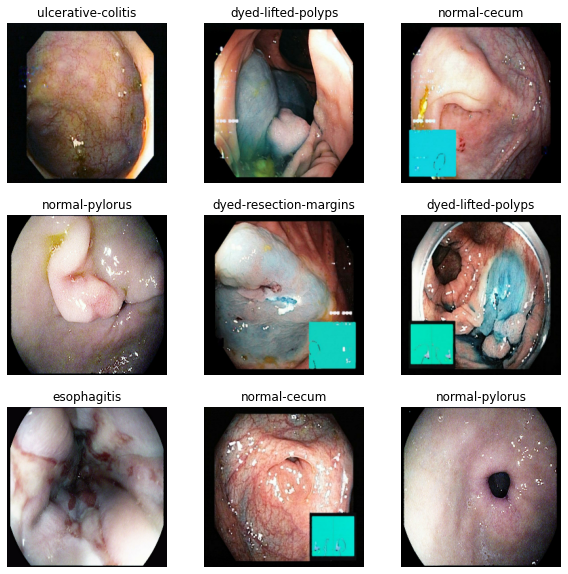

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**Examples of augmented images:**

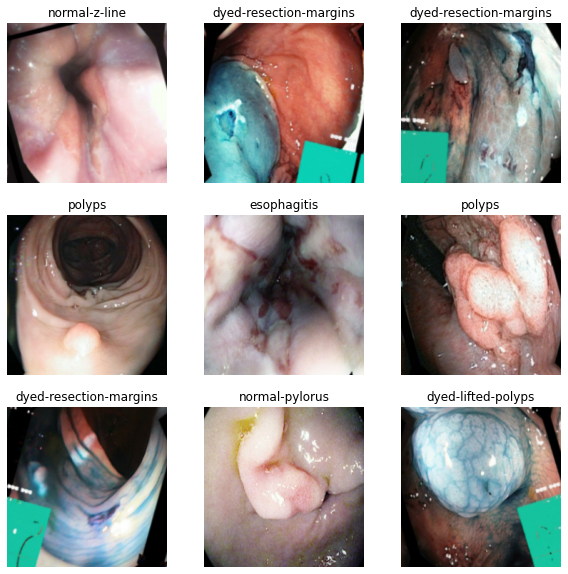

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare Test dataset

In [23]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 1600 files belonging to 8 classes.


In [24]:
test_ds_aug = augument_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
i = 0
y = np.zeros(shape=(1600,8))
for inputs_batch, labels_batch in test_ds_norm:
  #print(inputs_batch.shape)
  y[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= 1600:
      break

In [27]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

# CNN Model



In [28]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

num_classes = 8

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
filepath="weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, callback]

model2 = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  #layers.Dense(256, activation='relu'),
  #layers.Dropout(0.35),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

In [29]:
opt1=optimizers.RMSprop(learning_rate=2e-5)

In [30]:
opt2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

In [31]:
opt3=optimizers.RMSprop(learning_rate=0.001)

In [32]:
model2.compile(
  optimizer=opt1,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [33]:
hist_cnn_m2 = model2.fit(train_ds_norm,
  epochs=20,callbacks=[callbacks_list],
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.4991
Epoch 1: val_accuracy improved from -inf to 0.61125, saving model to weights.best.hdf5
400/400 [==============================] - 1196s 3s/step - loss: 1.2766 - accuracy: 0.4991 - val_loss: 0.9433 - val_accuracy: 0.6112
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.9618 - accuracy: 0.6073
Epoch 2: val_accuracy improved from 0.61125 to 0.64406, saving model to weights.best.hdf5
400/400 [==============================] - 141s 353ms/step - loss: 0.9618 - accuracy: 0.6073 - val_loss: 0.8792 - val_accuracy: 0.6441
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.8692 - accuracy: 0.6639
Epoch 3: val_accuracy improved from 0.64406 to 0.65906, saving model to weights.best.hdf5
400/400 [==============================] - 141s 354ms/step - loss: 0.8692 - accuracy: 0.6639 - val_loss: 0.8451 - val_accuracy: 0.6591
Epoch 4/20
400/400 [======================

In [34]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

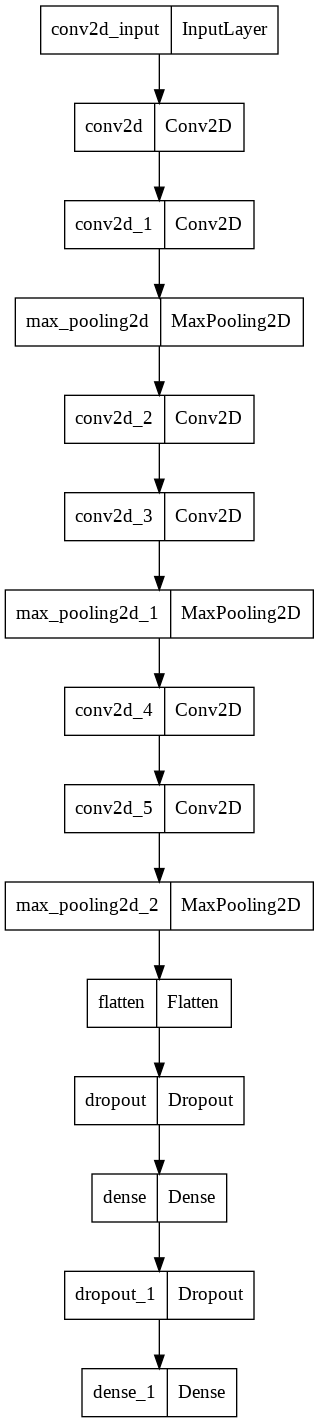

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(model2, "my_first_model.png")

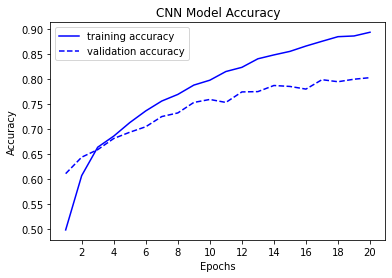

In [36]:
import matplotlib.pyplot as plt

acc = hist_cnn_m2.history['accuracy']
val_acc = hist_cnn_m2.history['val_accuracy']
loss = hist_cnn_m2.history['loss']
val_loss = hist_cnn_m2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('CNN Model Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'b--', label='validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, len(acc)+1, 2))
plt.legend()


plt.show()

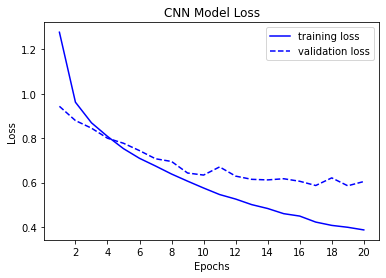

In [37]:


plt.title('CNN Model Loss')
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'b--', label='validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, len(loss)+1, 2))
plt.legend()


plt.show()

In [38]:
hist_cnn_m2 = model2.fit(val_ds_norm,
  epochs=10,callbacks=[callbacks_list],
  validation_data = train_ds_norm
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.7706
Epoch 1: val_accuracy improved from 0.80250 to 0.92242, saving model to weights.best.hdf5
100/100 [==============================] - 76s 763ms/step - loss: 0.6503 - accuracy: 0.7706 - val_loss: 0.3868 - val_accuracy: 0.9224
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.7859
Epoch 2: val_accuracy did not improve from 0.92242
100/100 [==============================] - 75s 756ms/step - loss: 0.6180 - accuracy: 0.7859 - val_loss: 0.4065 - val_accuracy: 0.9062
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.8069
Epoch 3: val_accuracy did not improve from 0.92242
100/100 [==============================] - 75s 756ms/step - loss: 0.5745 - accuracy: 0.8069 - val_loss: 0.4100 - val_accuracy: 0.8914
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.8266
Epoch 4: val_accuracy 

In [39]:
model2.evaluate(test_ds_norm)

50/50 [==============================] - 5s 107ms/step - loss: 1.5189 - accuracy: 0.4769


[1.5189024209976196, 0.4768750071525574]

In [40]:
test_pred = model2.predict(test_ds_norm)

50/50 [==============================] - 5s 103ms/step


In [41]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y[:], axis=1), np.argmax(test_pred[:], axis=1)))

              precision    recall  f1-score   support

           0       0.53      0.75      0.62       200
           1       0.76      0.30      0.44       200
           2       0.85      0.06      0.10       200
           3       0.68      0.92      0.78       200
           4       0.45      0.10      0.16       200
           5       0.47      0.64      0.54       200
           6       0.69      0.24      0.36       200
           7       0.29      0.81      0.42       200

    accuracy                           0.48      1600
   macro avg       0.59      0.48      0.43      1600
weighted avg       0.59      0.48      0.43      1600



In [42]:
"""
   The functions uses displays the confusion matrix
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.BuPu):
    """
       display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

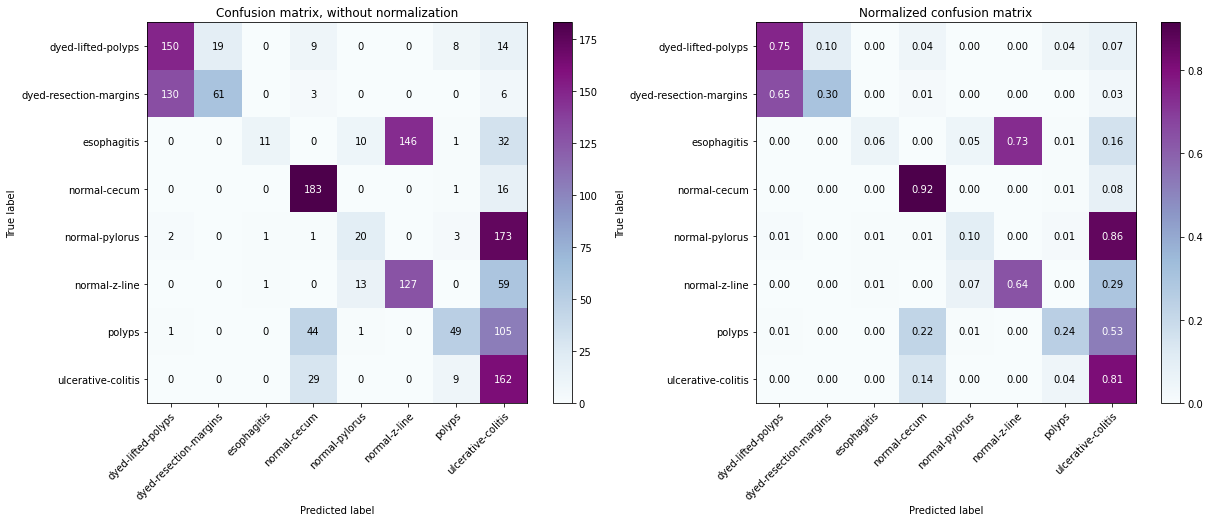

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(test_pred, axis=1))
plt_confusion_mat(cm, classes=categories, fig_size=(20, 7))

# Hyperparameters tuning



In [44]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [45]:
def get_model(num_classes = 8, drop_out=0.4, reg=None, n_densenodes=256):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=reg))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same',
                kernel_regularizer=reg))

  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out))

  model.add(layers.Dense(n_densenodes, activation='relu', kernel_regularizer=reg))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg))
  
  return model

In [46]:
def optimizer_search(iters=10):
  
  opt1 = optimizers.RMSprop(learning_rate=2e-5)
  opt2 = optimizers.RMSprop(learning_rate=2e-4)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt4 = optimizers.SGD(learning_rate=0.001, momentum=0.9)
  opt5 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
  opt6 = optimizers.SGD(learning_rate=0.01, momentum=0.9)
  opt7 = optimizers.SGD(learning_rate=0.0001, momentum=0.8)
  opt8 = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
  opt9 = optimizers.Adam()

  opt_list = [opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8, opt9]
  opt_name = ['RMSprop(learning_rate=2e-5)', 
              'RMSprop(learning_rate=2e-4)', 
              'SGD(learning_rate=0.001, momentum=0.8)',
              'SGD(learning_rate=0.001, momentum=0.9)',
              'SGD(learning_rate=0.01, momentum=0.8)',
              'SGD(learning_rate=0.01, momentum=0.9)',
              'SGD(learning_rate=0.0001, momentum=0.8)',
              'SGD(learning_rate=0.0001, momentum=0.9)',
              'adam']
  opt_hist=[]

  # regularizers.l2(1e-4)

  # 1. pick optimizer
  
  
  for i, opt in enumerate(opt_list):
    print(opt_name[i])
    model = get_model()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    opt_hist.append(h)
    print("")
  
  return opt_hist, opt_name



  """
  for m in momentums:
    model = get_model()
    opt = tf.keras.optimizers.SGD(lr=best_lr, momentum = m)
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(normtrain_ds ,epochs=iters)
    score = model.evaluate(normval_ds, verbose=0)
    if score[1] > best_acc:
      best_acc = score[1]
      best_mom = m

  print('best lr: ', best_lr)
  print('best momentum: ', best_mom)"""

  


In [47]:
opt_hist = optimizer_search()

RMSprop(learning_rate=2e-5)
Epoch 1/15
400/400 [==============================] - 135s 336ms/step - loss: 1.1938 - accuracy: 0.4916 - val_loss: 0.8641 - val_accuracy: 0.6153
Epoch 2/15
400/400 [==============================] - 135s 338ms/step - loss: 0.8635 - accuracy: 0.6149 - val_loss: 0.7397 - val_accuracy: 0.6644
Epoch 3/15
400/400 [==============================] - 135s 338ms/step - loss: 0.7551 - accuracy: 0.6677 - val_loss: 0.7121 - val_accuracy: 0.6750
Epoch 4/15
400/400 [==============================] - 135s 339ms/step - loss: 0.6893 - accuracy: 0.6995 - val_loss: 0.6728 - val_accuracy: 0.6909
Epoch 5/15
400/400 [==============================] - 135s 339ms/step - loss: 0.6402 - accuracy: 0.7240 - val_loss: 0.6670 - val_accuracy: 0.7000
Epoch 6/15
400/400 [==============================] - 135s 339ms/step - loss: 0.5916 - accuracy: 0.7450 - val_loss: 0.6176 - val_accuracy: 0.7181
Epoch 7/15
400/400 [==============================] - 136s 339ms/step - loss: 0.5613 - accuracy:

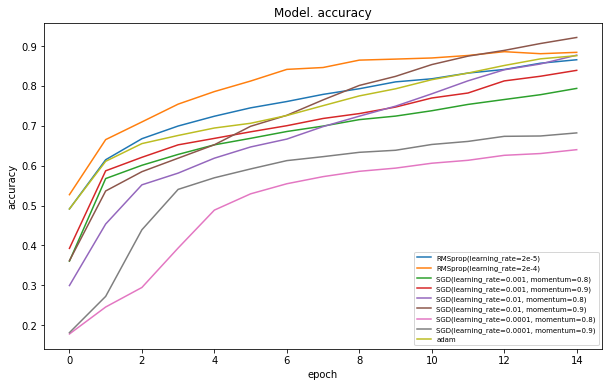

In [48]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['accuracy'])
plt.plot(opt_hist[0][1].history['accuracy'])
plt.plot(opt_hist[0][2].history['accuracy'])
plt.plot(opt_hist[0][3].history['accuracy'])
plt.plot(opt_hist[0][4].history['accuracy'])
plt.plot(opt_hist[0][5].history['accuracy'])
plt.plot(opt_hist[0][6].history['accuracy'])
plt.plot(opt_hist[0][7].history['accuracy'])
plt.plot(opt_hist[0][8].history['accuracy'])


plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


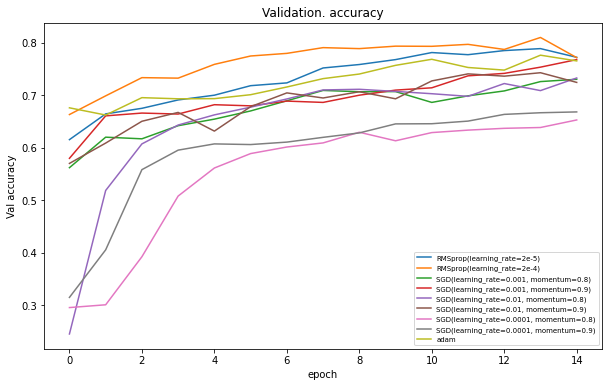

In [49]:
plt.figure(figsize=(10, 6))  

plt.plot(opt_hist[0][0].history['val_accuracy'])
plt.plot(opt_hist[0][1].history['val_accuracy'])
plt.plot(opt_hist[0][2].history['val_accuracy'])
plt.plot(opt_hist[0][3].history['val_accuracy'])
plt.plot(opt_hist[0][4].history['val_accuracy'])
plt.plot(opt_hist[0][5].history['val_accuracy'])
plt.plot(opt_hist[0][6].history['val_accuracy'])
plt.plot(opt_hist[0][7].history['val_accuracy'])
plt.plot(opt_hist[0][8].history['val_accuracy'])

plt.title('Validation. accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


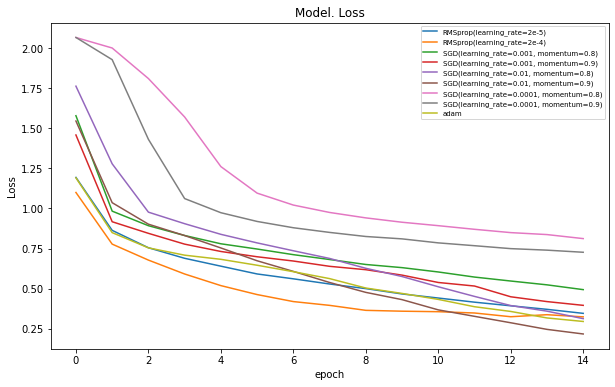

In [50]:
plt.figure(figsize=(10, 6))  


plt.plot(opt_hist[0][0].history['loss'])
plt.plot(opt_hist[0][1].history['loss'])
plt.plot(opt_hist[0][2].history['loss'])
plt.plot(opt_hist[0][3].history['loss'])
plt.plot(opt_hist[0][4].history['loss'])
plt.plot(opt_hist[0][5].history['loss'])
plt.plot(opt_hist[0][6].history['loss'])
plt.plot(opt_hist[0][7].history['loss'])
plt.plot(opt_hist[0][8].history['loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


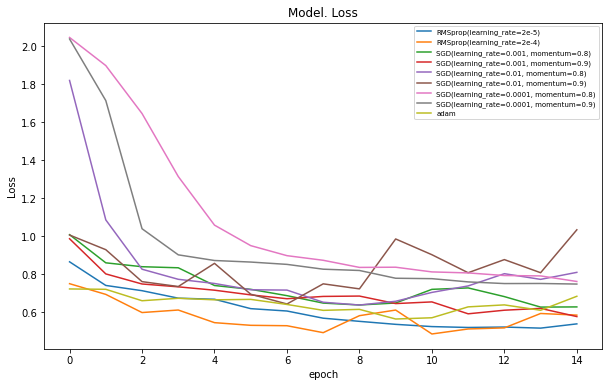

In [51]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['val_loss'])
plt.plot(opt_hist[0][1].history['val_loss'])
plt.plot(opt_hist[0][2].history['val_loss'])
plt.plot(opt_hist[0][3].history['val_loss'])
plt.plot(opt_hist[0][4].history['val_loss'])
plt.plot(opt_hist[0][5].history['val_loss'])
plt.plot(opt_hist[0][6].history['val_loss'])
plt.plot(opt_hist[0][7].history['val_loss'])
plt.plot(opt_hist[0][8].history['val_loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


In [52]:

def reguralizer_search(iters=10):
  
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  reg1 = regularizers.l2(1e-4)
  reg2 = regularizers.l1(1e-5)
  reg3 = regularizers.l2(1e-5)
  reg4 = regularizers.l2(1e-3)

  reg_list = [reg1, reg2, reg3, reg4]
  reg_name = ['regularizers.l2(1e-4)', 
              'regularizers.l1(1e-5)', 
              'regularizers.l2(1e-5)',
              'regularizers.l2(1e-3)']
  reg_hist=[]

  # regularizers.l2(1e-4)

  # 2. pick regularizer
  for i, r in enumerate(reg_list):
    print(reg_name[i])
    model = get_model(reg=r)
    model.compile(optimizer=opt3, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm,callbacks=[callbacks_list])
    reg_hist.append(h)
    print("")
  
  return reg_hist, reg_name



In [53]:
reg_hist = reguralizer_search()

regularizers.l2(1e-4)
Epoch 1/15
400/400 [==============================] - ETA: 0s - loss: 1.7521 - accuracy: 0.3170
Epoch 1: val_accuracy did not improve from 0.92242
400/400 [==============================] - 133s 331ms/step - loss: 1.7521 - accuracy: 0.3170 - val_loss: 1.1129 - val_accuracy: 0.5581
Epoch 2/15
400/400 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.5593
Epoch 2: val_accuracy did not improve from 0.92242
400/400 [==============================] - 132s 331ms/step - loss: 1.0600 - accuracy: 0.5593 - val_loss: 0.8975 - val_accuracy: 0.6266
Epoch 3/15
400/400 [==============================] - ETA: 0s - loss: 0.9469 - accuracy: 0.5996
Epoch 3: val_accuracy did not improve from 0.92242
400/400 [==============================] - 132s 331ms/step - loss: 0.9469 - accuracy: 0.5996 - val_loss: 0.8508 - val_accuracy: 0.6400
Epoch 4/15
400/400 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.6311
Epoch 4: val_accuracy did not improv

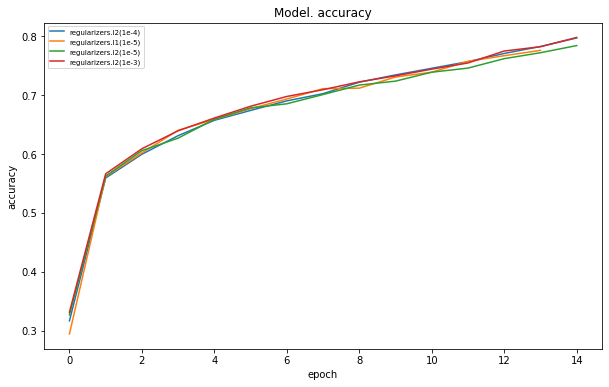

In [54]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['accuracy'])
plt.plot(reg_hist[0][1].history['accuracy'])
plt.plot(reg_hist[0][2].history['accuracy'])
plt.plot(reg_hist[0][3].history['accuracy'])



plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


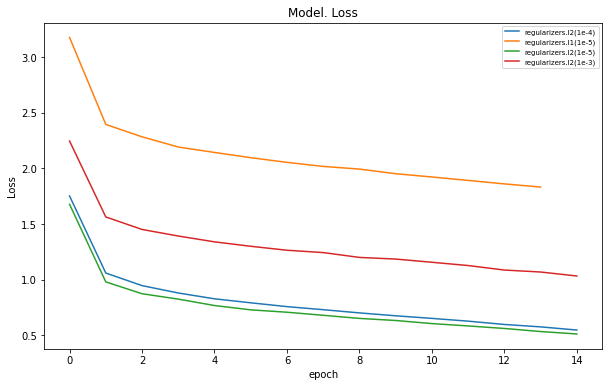

In [55]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['loss'])
plt.plot(reg_hist[0][1].history['loss'])
plt.plot(reg_hist[0][2].history['loss'])
plt.plot(reg_hist[0][3].history['loss'])



plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


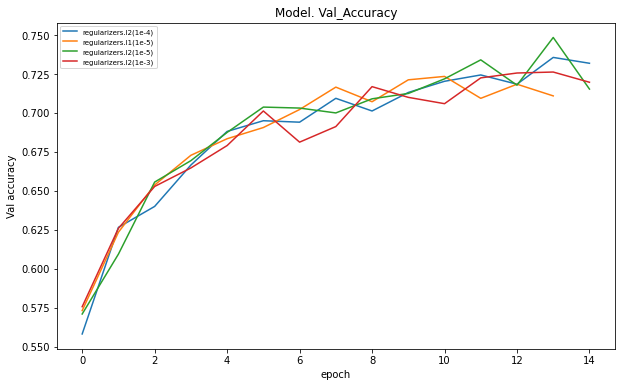

In [56]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_accuracy'])
plt.plot(reg_hist[0][1].history['val_accuracy'])
plt.plot(reg_hist[0][2].history['val_accuracy'])
plt.plot(reg_hist[0][3].history['val_accuracy'])



plt.title('Model. Val_Accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


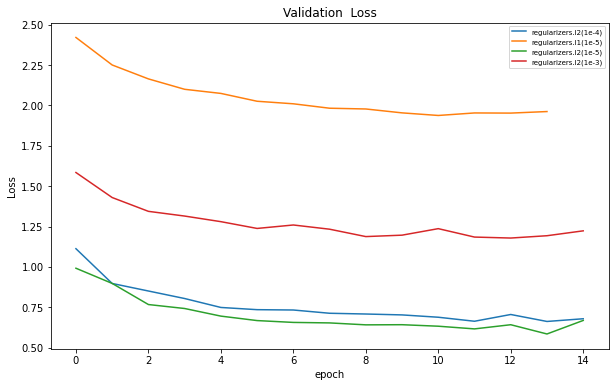

In [57]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_loss'])
plt.plot(reg_hist[0][1].history['val_loss'])
plt.plot(reg_hist[0][2].history['val_loss'])
plt.plot(reg_hist[0][3].history['val_loss'])



plt.title('Validation  Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


# Learn and extract image features

## VGG16

In [58]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [59]:


# load model without classifier layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [60]:
opt1 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(learning_rate=2e-5)
opt3="adam"

In [61]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [62]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - 205s 504ms/step - loss: 1.0560 - accuracy: 0.6008 - val_loss: 0.5307 - val_accuracy: 0.7941
Epoch 2/20
400/400 [==============================] - 202s 506ms/step - loss: 0.4927 - accuracy: 0.8255 - val_loss: 0.3442 - val_accuracy: 0.8747
Epoch 3/20
400/400 [==============================] - 202s 505ms/step - loss: 0.3422 - accuracy: 0.8830 - val_loss: 0.3038 - val_accuracy: 0.9013
Epoch 4/20
400/400 [==============================] - 203s 507ms/step - loss: 0.2604 - accuracy: 0.9153 - val_loss: 0.2397 - val_accuracy: 0.9278
Epoch 5/20
400/400 [==============================] - 203s 507ms/step - loss: 0.2020 - accuracy: 0.9384 - val_loss: 0.2643 - val_accuracy: 0.9241
Epoch 6/20
400/400 [==============================] - 203s 507ms/step - loss: 0.1655 - accuracy: 0.9542 - val_loss: 0.3029 - val_accuracy: 0.9272
Epoch 7/20
400/400 [==============================] - 203s 507ms/step - loss: 0.1413 - accuracy: 0.9623 - val_loss: 0.2562 -

In [63]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
500/500 [==============================] - 234s 467ms/step - loss: 0.1188 - accuracy: 0.9704
Epoch 2/14
500/500 [==============================] - 232s 464ms/step - loss: 0.0820 - accuracy: 0.9797
Epoch 3/14
500/500 [==============================] - 232s 464ms/step - loss: 0.0749 - accuracy: 0.9814
Epoch 4/14
500/500 [==============================] - 232s 465ms/step - loss: 0.0707 - accuracy: 0.9836
Epoch 5/14
500/500 [==============================] - 232s 464ms/step - loss: 0.0584 - accuracy: 0.9870
Epoch 6/14
500/500 [==============================] - 232s 463ms/step - loss: 0.0634 - accuracy: 0.9863
Epoch 7/14
500/500 [==============================] - 232s 464ms/step - loss: 0.0607 - accuracy: 0.9882
Epoch 8/14
500/500 [==============================] - 231s 463ms/step - loss: 0.0642 - accuracy: 0.9870
Epoch 9/14
500/500 [==============================] - 232s 463ms/step - loss: 0.0722 - accuracy: 0.9872
Epoch 10/14
500/500 [==============================] - 231s 462m

In [64]:
model.save("vgg16.h5")

In [65]:
from keras.models import load_model

In [66]:
model_vgg = load_model('vgg16.h5')

In [67]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [68]:
vgg_features_model = Model (model_vgg.layers[0].input,  model_vgg.layers[21].output)

In [69]:
vgg_features_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [70]:
model_vgg.evaluate(test_ds_norm)

50/50 [==============================] - 8s 163ms/step - loss: 0.9141 - accuracy: 0.8575


[0.9141497015953064, 0.8575000166893005]

In [71]:
predict_test = model_vgg.predict(test_ds_norm)

50/50 [==============================] - 8s 163ms/step


In [72]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(predict_test, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       200
           1       0.94      0.91      0.93       200
           2       0.77      0.64      0.70       200
           3       0.92      0.95      0.94       200
           4       0.88      0.92      0.89       200
           5       0.72      0.72      0.72       200
           6       0.86      0.89      0.87       200
           7       0.85      0.95      0.90       200

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600



In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average='weighted')

0.8561611484796

In [74]:
np.average(recall_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.8574999999999999

In [75]:
np.average(f1_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.855494629939081

In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))


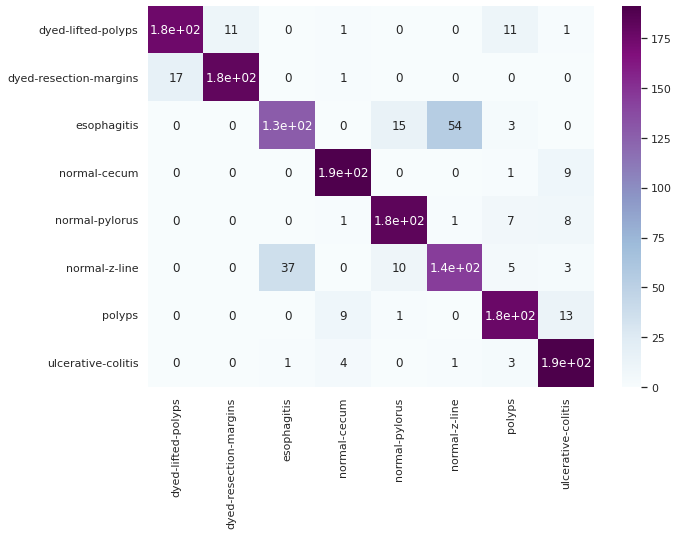

In [77]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

In [78]:
df_cm

,dyed-lifted-polyps,dyed-resection-margins,esophagitis,normal-cecum,normal-pylorus,normal-z-line,polyps,ulcerative-colitis
dyed-lifted-polyps,176,11,0,1,0,0,11,1
dyed-resection-margins,17,182,0,1,0,0,0,0
esophagitis,0,0,128,0,15,54,3,0
normal-cecum,0,0,0,190,0,0,1,9
normal-pylorus,0,0,0,1,183,1,7,8
normal-z-line,0,0,37,0,10,145,5,3
polyps,0,0,0,9,1,0,177,13
ulcerative-colitis,0,0,1,4,0,1,3,191


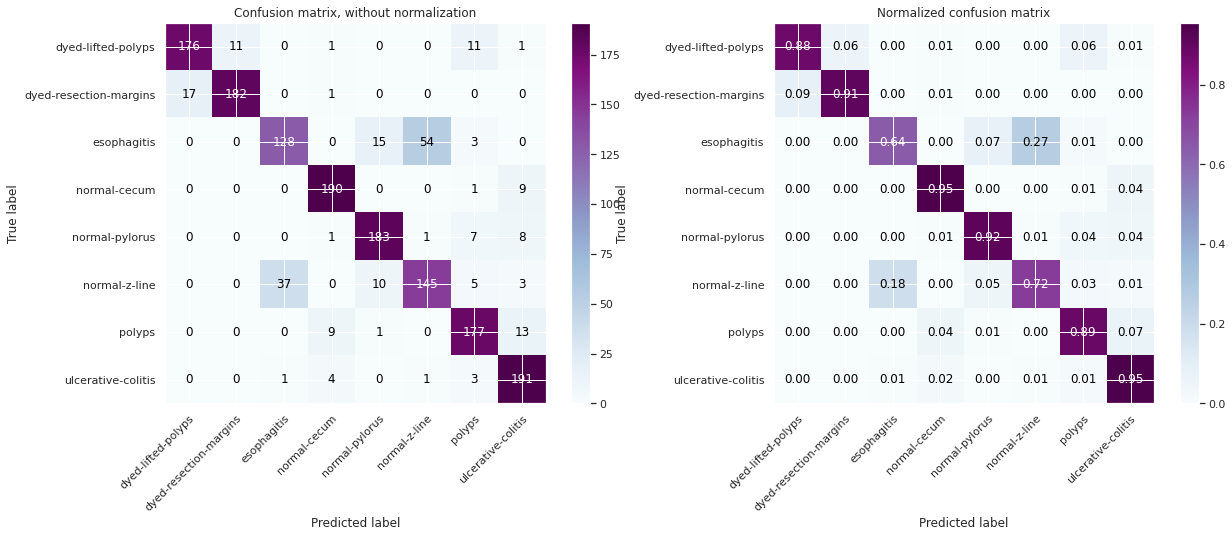

In [79]:
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
plt_confusion_mat(cm, classes=class_names, fig_size=(20, 7))

## DenseNet-169

In [80]:
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers

# load model without classifier layers
model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.5)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)

# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

51877672/51877672 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [81]:
model.compile(
  optimizer=optimizers.RMSprop(learning_rate=2e-5),
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [82]:
history3 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - 231s 499ms/step - loss: 1.1477 - accuracy: 0.6154 - val_loss: 0.3416 - val_accuracy: 0.8706
Epoch 2/20
400/400 [==============================] - 197s 492ms/step - loss: 0.3961 - accuracy: 0.8675 - val_loss: 0.2551 - val_accuracy: 0.9206
Epoch 3/20
400/400 [==============================] - 197s 492ms/step - loss: 0.2141 - accuracy: 0.9335 - val_loss: 0.2088 - val_accuracy: 0.9450
Epoch 4/20
400/400 [==============================] - 197s 492ms/step - loss: 0.1309 - accuracy: 0.9656 - val_loss: 0.2381 - val_accuracy: 0.9444
Epoch 5/20
400/400 [==============================] - 197s 492ms/step - loss: 0.0769 - accuracy: 0.9813 - val_loss: 0.2399 - val_accuracy: 0.9531
Epoch 6/20
400/400 [==============================] - 197s 493ms/step - loss: 0.0596 - accuracy: 0.9897 - val_loss: 0.2036 - val_accuracy: 0.9606
Epoch 7/20
400/400 [==============================] - 197s 492ms/step - loss: 0.0466 - accuracy: 0.9929 - val_loss: 0.2766 -

In [83]:
model.fit(train_all_norm,
          epochs=17)

Epoch 1/17
500/500 [==============================] - 231s 463ms/step - loss: 0.1046 - accuracy: 0.9736
Epoch 2/17
500/500 [==============================] - 231s 463ms/step - loss: 0.0313 - accuracy: 0.9919
Epoch 3/17
500/500 [==============================] - 231s 463ms/step - loss: 0.0165 - accuracy: 0.9968
Epoch 4/17
500/500 [==============================] - 231s 463ms/step - loss: 0.0115 - accuracy: 0.9974
Epoch 5/17
500/500 [==============================] - 231s 463ms/step - loss: 0.0095 - accuracy: 0.9986
Epoch 6/17
500/500 [==============================] - 232s 464ms/step - loss: 0.0075 - accuracy: 0.9987
Epoch 7/17
500/500 [==============================] - 232s 463ms/step - loss: 0.0072 - accuracy: 0.9989
Epoch 8/17
500/500 [==============================] - 232s 463ms/step - loss: 0.0063 - accuracy: 0.9991
Epoch 9/17
500/500 [==============================] - 231s 463ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 10/17
500/500 [==============================] - 231s 462m

In [84]:
model.evaluate(test_ds_norm)

50/50 [==============================] - 6s 118ms/step - loss: 1.1269 - accuracy: 0.8913


[1.1268795728683472, 0.8912500143051147]

In [85]:
predict_test = model.predict(test_ds_norm)

50/50 [==============================] - 8s 114ms/step


In [86]:
predict_test.shape

(1600, 8)

In [87]:
model.save("densenet.h5")

In [88]:
from keras.models import load_model
model_dn = load_model('densenet.h5')

In [89]:
model_dn.summary ()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [90]:
dn_features_model = Model (model_dn.layers[0].input,  model_dn.layers[597].output)

In [91]:
dn_features_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [92]:
pred_test = model.predict(test_ds_norm)

50/50 [==============================] - 6s 113ms/step


In [93]:
from sklearn.metrics import precision_score, recall_score, f1_score
np.average(precision_score(np.argmax(y, axis=1), np.argmax(pred_test, axis=1), average='weighted'))

0.9025209370615337

In [94]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(pred_test, axis=1))


In [143]:
cm

array([[184,   7,   0,   2,   0,   0,   6,   1],
       [ 16, 182,   0,   2,   0,   0,   0,   0],
       [  0,   0, 117,   1,  12,  66,   1,   3],
       [  0,   0,   0, 196,   0,   0,   0,   4],
       [  0,   0,   0,   0, 199,   0,   1,   0],
       [  0,   0,   6,   0,   8, 185,   1,   0],
       [  0,   0,   0,  10,   1,   0, 181,   8],
       [  0,   0,   0,   5,   0,   1,   2, 192]])

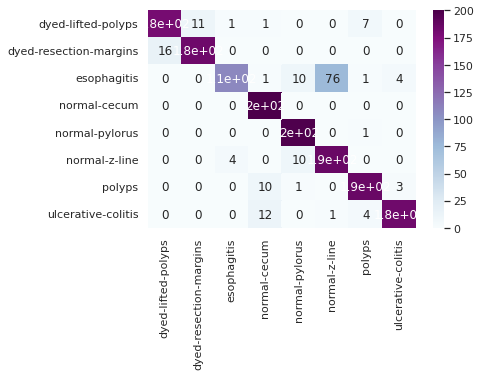

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Save features to pickle file for future use

In [96]:
import pandas as pd

In [97]:
vgg_features = vgg_features_model.predict(train_ds_norm)
vgg_features_val = vgg_features_model.predict(val_ds_norm)
vgg_features_test = vgg_features_model.predict(test_ds_norm)

50/50 [==============================] - 10s 205ms/step


In [98]:
df_features = pd.DataFrame(vgg_features)
df_features.to_pickle("vgg_features.pkl")
df_features = pd.DataFrame(vgg_features_val)
df_features.to_pickle("vgg_features_val.pkl")
df_features = pd.DataFrame(vgg_features_test)
df_features.to_pickle("vgg_features_test.pkl")

In [99]:
dn_features = dn_features_model.predict(train_ds_norm)
dn_features_val = dn_features_model.predict(val_ds_norm)
dn_features_test = dn_features_model.predict(test_ds_norm)

50/50 [==============================] - 5s 109ms/step


In [100]:
y_train = np.concatenate([y for x, y in train_ds_norm], axis=0)
y_val = np.concatenate([y for x, y in val_ds_norm], axis=0)
y_test = np.concatenate([y for x, y in test_ds_norm], axis=0)

In [101]:
df_features = pd.DataFrame(dn_features)
df_features["label"] = np.argmax(y_train, axis=1)
df_features.to_pickle("dn_features.pkl")

df_features = pd.DataFrame(dn_features_val)
df_features["label"] = np.argmax(y_val, axis=1)
df_features.to_pickle("dn_features_val.pkl")

df_features = pd.DataFrame(dn_features_test)
df_features["label"] = np.argmax(y_test, axis=1)
df_features.to_pickle("dn_features_test.pkl")

In [102]:
import pandas as pd
import numpy as np

In [103]:
vgg_features = np.array(pd.read_pickle("vgg_features.pkl"))
dn_features = np.array(pd.read_pickle("dn_features.pkl"))
vgg_features_val = np.array(pd.read_pickle("vgg_features_val.pkl"))
dn_features_val = np.array(pd.read_pickle("dn_features_val.pkl"))
vgg_features_test = np.array(pd.read_pickle("vgg_features_test.pkl"))
dn_features_test = np.array(pd.read_pickle("dn_features_test.pkl"))

In [104]:
# extract class labels
y_train = dn_features[:,-1]
y_val = dn_features_val[:,-1]
y_test = dn_features_test[:,-1]

In [105]:
dn_features_val = dn_features_val[:,:-1]
dn_features = dn_features[:,:-1]
dn_features_test = dn_features_test[:,:-1]

In [106]:
combined_features = np.concatenate ((dn_features, vgg_features), axis=1)
combined_features_val = np.concatenate ((dn_features_val, vgg_features_val), axis=1)
combined_features_test = np.concatenate ((dn_features_test, vgg_features_test), axis=1)

In [107]:
# 256 features from VGG16 + 256 features from DenseNet169
print ("combined_features.shape: ", combined_features.shape)
print ("combined_features_val.shape: ", combined_features_val.shape)
print ("combined_features_test.shape: ", combined_features_test.shape)

combined_features.shape:  (12800, 512)
combined_features_val.shape:  (3200, 512)
combined_features_test.shape:  (1600, 512)


In [108]:
import time
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [109]:
feat_cols = [ 'pixel'+str(i) for i in range(combined_features.shape[1]) ]
df = pd.DataFrame(combined_features,columns=feat_cols)
df['class'] = y_train
df['label'] = df['class'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (12800, 514)


In [110]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [111]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [112]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12800 samples in 0.004s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 12800 samples in 3.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12800
[t-SNE] Computed conditional probabilities for sample 2000 / 12800
[t-SNE] Computed conditional probabilities for sample 3000 / 12800
[t-SNE] Computed conditional probabilities for sample 4000 / 12800
[t-SNE] Computed conditional probabilities for sample 5000 / 12800
[t-SNE] Computed conditional probabilities for sample 6000 / 12800
[t-SNE] Computed conditional probabilities for sample 7000 / 12800
[t-SNE] Computed conditional probabilities for sample 8000 / 12800
[t-SNE] Computed conditional probabilities for sample 9000 / 12800
[t-SNE] Computed conditional probabilities for sample 10000 / 12800
[t-SNE] Computed conditional probabilities for sample 11000 / 12800
[t-SNE] Computed conditional probabilities for sample 12000 / 12800
[t-SNE] Computed conditional probabilities for sample 12800 / 12800
[t-SNE] Mean sigma: 5.626827
[t-SNE] KL divergence after 250 iterat

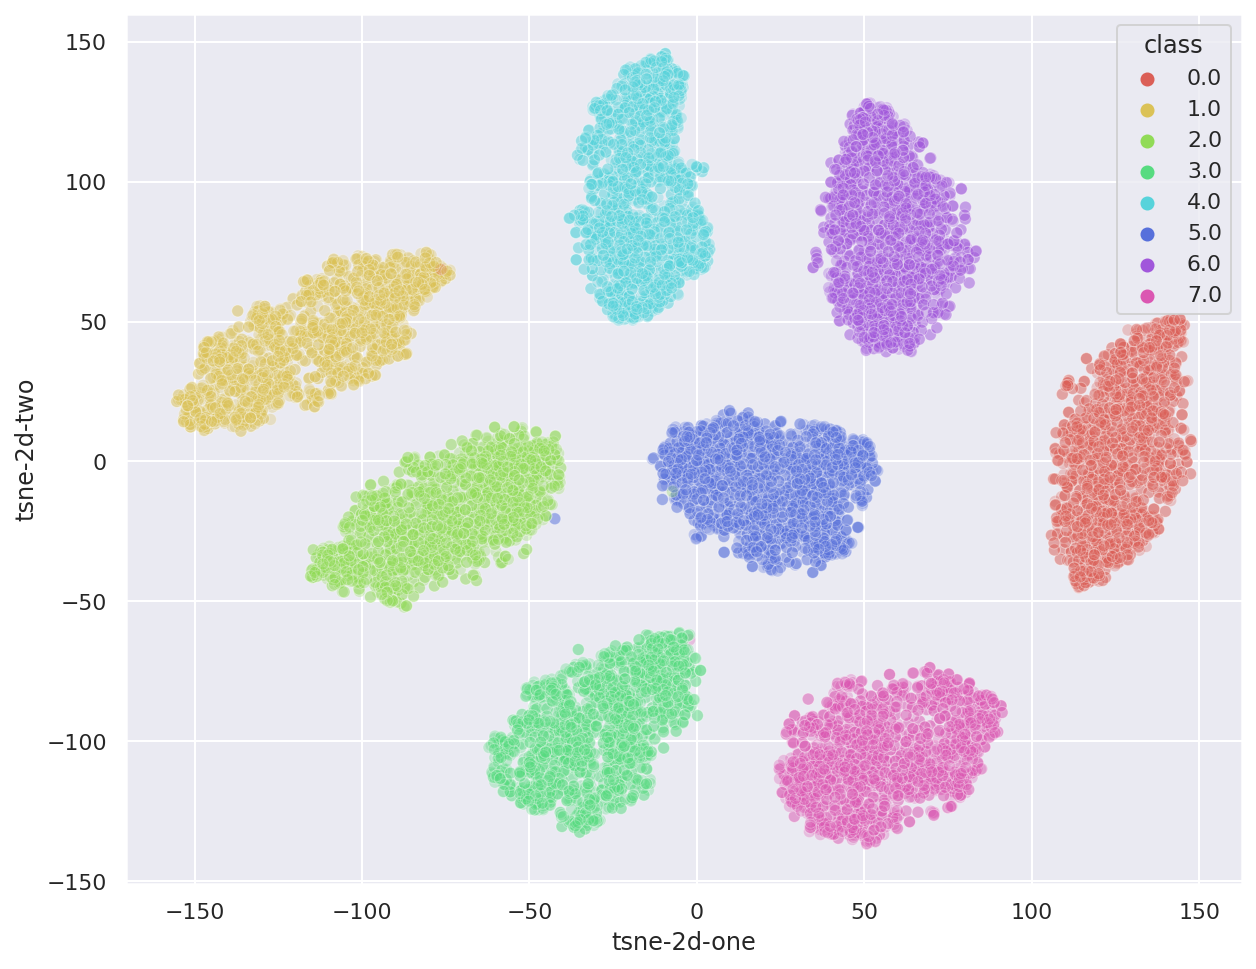

In [113]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3
)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [115]:
lr = LogisticRegression(max_iter=10000)

In [116]:
combined_features_all = np.concatenate((combined_features, combined_features_val))
y_train_all = np.concatenate((y_train, y_val))

In [117]:
combined_features_all.shape

(16000, 512)

In [118]:
y_train_all.shape

(16000,)

In [119]:
lr.fit(combined_features, y_train)

LogisticRegression(max_iter=10000)

In [120]:
from sklearn.metrics import accuracy_score

# training set accuracy
y_pred = lr.predict(combined_features_test)
accuracy_score( y_test, y_pred)

0.8975

In [121]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [122]:
precision_score(y_test, y_pred, average="weighted")

0.9057559472060234

In [123]:
recall_score(y_test, y_pred, average="weighted")

0.8975

In [124]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [125]:
cm

array([[184,   7,   0,   2,   0,   0,   6,   1],
       [ 16, 182,   0,   2,   0,   0,   0,   0],
       [  0,   0, 117,   1,  12,  66,   1,   3],
       [  0,   0,   0, 196,   0,   0,   0,   4],
       [  0,   0,   0,   0, 199,   0,   1,   0],
       [  0,   0,   6,   0,   8, 185,   1,   0],
       [  0,   0,   0,  10,   1,   0, 181,   8],
       [  0,   0,   0,   5,   0,   1,   2, 192]])

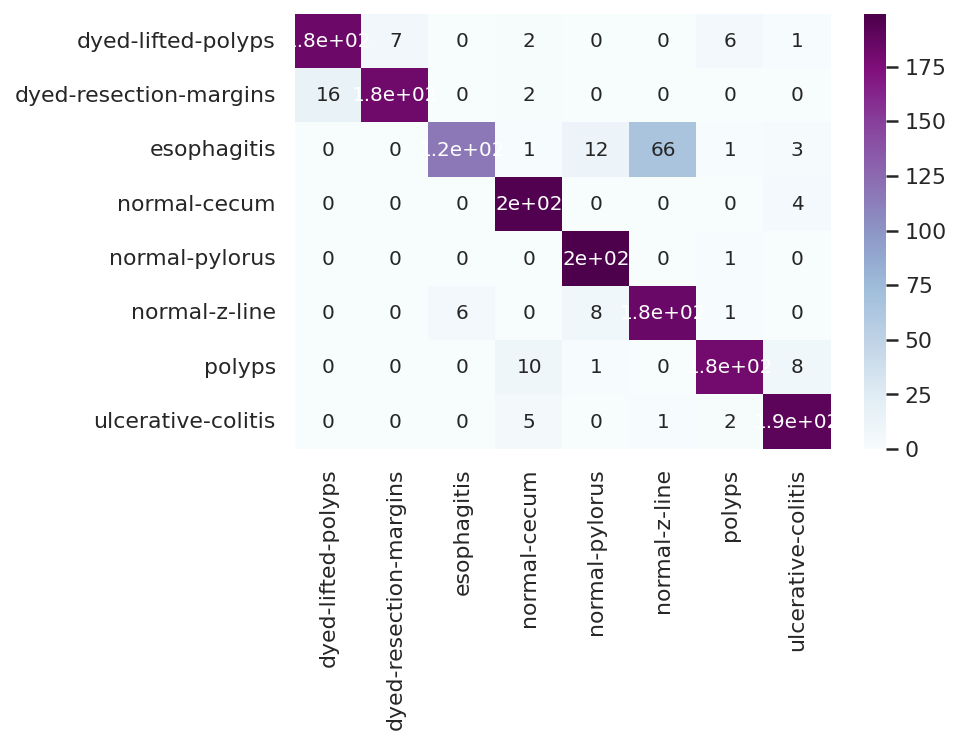

In [126]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="BuPu") # font size

plt.show()

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [128]:
mlp = MLPClassifier()
mlp.fit(combined_features, y_train)

MLPClassifier()

In [129]:
dt = DecisionTreeClassifier()
dt.fit(combined_features, y_train)

DecisionTreeClassifier()

In [130]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(combined_features, y_train)

KNeighborsClassifier(n_neighbors=20)

In [131]:
pred_test1 = neigh.predict(combined_features_test)

In [132]:
pred_test2 = dt.predict(combined_features_test)

In [133]:
pred_test3 = mlp.predict(combined_features_test)

In [134]:
accuracy_score(y_test, pred_test1) # KNeighborsClassifier accuracy

0.9

In [135]:
accuracy_score(y_test, pred_test2) # DecisionTreeClassifier accuracy

0.871875

In [136]:
accuracy_score(y_test, pred_test3) # MLP classifier accuracy

0.889375

**InceptionResNetV2**

In [137]:
# load model without classifier layers
model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

219055592/219055592 [==============================] - 5s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_84[0][0]']              
 alization)              

In [138]:
opt1 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(learning_rate=2e-5)
opt3="adam"

In [139]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [140]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - 298s 664ms/step - loss: 1.0443 - accuracy: 0.6256 - val_loss: 0.4649 - val_accuracy: 0.8556
Epoch 2/20
400/400 [==============================] - 263s 657ms/step - loss: 0.3186 - accuracy: 0.9023 - val_loss: 0.5446 - val_accuracy: 0.9031
Epoch 3/20
400/400 [==============================] - 263s 657ms/step - loss: 0.1250 - accuracy: 0.9738 - val_loss: 0.8845 - val_accuracy: 0.9219
Epoch 4/20
400/400 [==============================] - 263s 657ms/step - loss: 0.0720 - accuracy: 0.9931 - val_loss: 1.1782 - val_accuracy: 0.9137
Epoch 5/20
400/400 [==============================] - 263s 657ms/step - loss: 0.0555 - accuracy: 0.9971 - val_loss: 1.2533 - val_accuracy: 0.9253
Epoch 6/20
400/400 [==============================] - 262s 656ms/step - loss: 0.0485 - accuracy: 0.9980 - val_loss: 1.8928 - val_accuracy: 0.9225
Epoch 7/20
400/400 [==============================] - 262s 656ms/step - loss: 0.0408 - accuracy: 0.9988 - val_loss: 1.7088 -

In [141]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
500/500 [==============================] - 306s 613ms/step - loss: 0.1555 - accuracy: 0.9607
Epoch 2/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0152 - accuracy: 0.9962
Epoch 3/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0068 - accuracy: 0.9983
Epoch 4/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0052 - accuracy: 0.9989
Epoch 5/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0040 - accuracy: 0.9991
Epoch 6/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0028 - accuracy: 0.9994
Epoch 7/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0032 - accuracy: 0.9994
Epoch 8/14
500/500 [==============================] - 306s 613ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 9/14
500/500 [==============================] - 306s 612ms/step - loss: 0.0020 - accuracy: 0.9997
Epoch 10/14
500/500 [==============================] - 307s 614m

In [144]:
model.save("InceptionResNetV2.h5")
from keras.models import load_model
model_InceptionResNetV2 = load_model('InceptionResNetV2.h5')
model_InceptionResNetV2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_84[0][0]']              
 alization)                     )                                                           

In [145]:
InceptionResNetV2 = Model (model_InceptionResNetV2.layers[0].input,  model_InceptionResNetV2.layers[21].output)

In [146]:
InceptionResNetV2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_84 (Conv2D)          (None, 111, 111, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 111, 111, 32)      0         
                                                                 
 conv2d_85 (Conv2D)          (None, 109, 109, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     96        
 hNormalization)                                           

In [147]:
model_InceptionResNetV2.evaluate(test_ds_norm)

50/50 [==============================] - 12s 183ms/step - loss: 4.2811 - accuracy: 0.8438


[4.281118869781494, 0.84375]

In [148]:
predict_test = model_InceptionResNetV2.predict(test_ds_norm)

50/50 [==============================] - 12s 180ms/step
